## Sentiment Analysis
https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

plot_size = plt.rcParams["figure.figsize"]  

plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)

In [3]:
ira_data['AD_ORIGINAL_TEXT'] = ira_data['AD_TEXT']
#ira_data['AD_CLICKS_PER_VIEW'] = ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS']
ira_data.insert(4, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

In [4]:
ira_data.head(10)

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,...,AD_TARGETING_INTERESTS,AD_TARGETING_LANGUAGE,AD_TARGETING_LOCATION,AD_TARGETING_LOCATION_LIVING_IN,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,AD_ORIGINAL_TEXT
AD_ID,,,,,,,,,,,,,,,,,,,,,
1,6.0,2015-10-25 06:28:33,2015-10-27 23:59:00,358.0,0.016760,https://www.instagram.com/us_daily/,2015-q4/2015-10/P(1)0001736.pdf,161.23 RUB,18 - 51,NaN,...,"News broadcasting, Political party, Breaking n...",English (US),NaN,United States,NaN,NaN,Instagram Feed,Instgogogo,52000000.0,Instgogogo
2,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,17256.0,0.002202,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,NaN,...,NaN,NaN,NaN,United States: Texas,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0,You can go to hell or follow @south_lone_star ...
3,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,NaN,...,Cop Block or Black (Color),English (US),NaN,United States,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0,Black lives matter because we see what's going...
4,33.0,2016-04-19 07:49:45,NaT,14311.0,0.002306,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,NaN,...,Cop Block,English (US),United States,NaN,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0,Don't Shoot is a community site where you can ...
5,201.0,2016-06-15 03:39:52,NaT,29786.0,0.006748,https://www.facebook.com/govspending-165176135...,2016-q2/2016-06/P(1)0000001.pdf,3714.15 RUB,18 - 65+,NaN,...,Understanding racial segregation in the united...,NaN,NaN,United States: Georgia,NaN,NaN,Instagram Feed,WHERE is your VOICE?,NaN,WHERE is your VOICE?
6,NaN,2016-05-12 04:06:17,NaT,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,...,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,Conservative Christians. Pro-life/ gun/ police...
7,54.0,2016-05-13 01:18:08,NaT,23408.0,0.002307,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,...,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,Conservative Christians. Pro-life/ gun/ police...
8,43.0,2016-03-11 05:04:42,NaT,9559.0,0.004498,https://www.instagram.com/black—america—today/,2016-q1/2016-03/P(1)0006379.pdf,2003.01 RUB,13 - 35,NaN,...,Hoodies or Trayvon Martin,English (UK)or English (US),United States,NaN,NaN,NaN,Instagram Feed,Trayvon Martin's lawyers wearing hoodies. Wear...,18000.0,Trayvon Martin's lawyers wearing hoodies. Wear...
9,13.0,2015-11-24 05:34:21,NaT,4871.0,0.002669,https://www.instagram.com/veterans_us/,2015-q4/2015-11/P(1)0001229.pdf,1052.89 RUB,18 - 65+,NaN,...,"Veterans Day, American Revolutionary War or Pa...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Edward was a combat engineer in Afghanistan wh...,3600000.0,Edward was a combat engineer in Afghanistan wh...


### Extract Hashtags
Extracting the Hashtags in case they are needed later

In [5]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

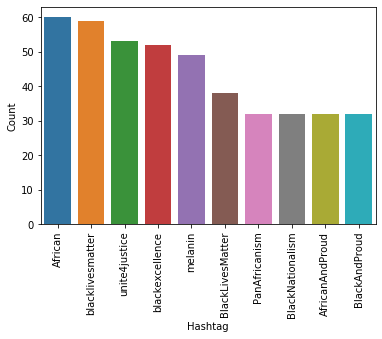

In [6]:
HT = hashtag_extract(ira_data['AD_TEXT'])
HT = sum(HT,[])

a = nltk.FreqDist(HT)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
#d.plot.bar()
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Removal of stopwords

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ira_data['AD_TEXT'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

AD_ID
1                                              Instgogogo
2       You go hell follow @south_lone_star instead! T...
3       Black lives matter see what's going on. We car...
4       Don't Shoot community site find recent videos ...
5                                            WHERE VOICE?
6       Conservative Christians. Pro-life/ gun/ police...
7       Conservative Christians. Pro-life/ gun/ police...
8       Trayvon Martin's lawyers wearing hoodies. Wear...
9       Edward combat engineer Afghanistan whose job c...
10      Unbelievable amount US government's waste. Joi...
11      Veterans Day coming! There many ways show supp...
12      It's time us understand deserve best. It's tim...
13      The original Statue Liberty France black. The ...
14      This military campaign ambiguous given cost ne...
15      And would choose u president: create 11200 mil...
16      A Wounded Warrior service dog. Support Veteran...
17      What know PTSD? There greater agony. PTSD affe...
18      

### Add column with word count

In [8]:
ira_data['WORD_COUNT'] = ira_data['AD_TEXT'].apply(lambda x: len(str(x).split(" ")))
ira_data = ira_data[ira_data['WORD_COUNT'] > 5]

### Removal of words with less than 5 characters

In [9]:
ira_data['AD_TEXT'] = ira_data['AD_TEXT'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>4]))

### Stemming
removal of suffices, like “ing”, “ly”, “s”, etc. 

In [10]:
st = PorterStemmer()
ira_data['AD_TEXT'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

AD_ID
2       follow @south_lone_star instead! texa where al...
3       black live matter becaus what' go care, won't ...
4       don't shoot commun where recent video about ou...
6       conserv christians. pro-life/ police/ military...
7       conserv christians. pro-life/ police/ military...
8       trayvon martin' lawyer wear hoodies. wear hood...
9       edward combat engin afghanistan whose clear ro...
10      unbeliev amount government' waste. learn about...
11      veteran coming! there support gratitude. milli...
12      understand deserv best. peopl stand opportun l...
13      origin statu liberti franc black. statu libert...
14      militari campaign ambigu given nearli 2,500 am...
15      would choos president: creat 11200 military- r...
16      wound warrior servic support veteran follow: s...
17      about ptsd? there greater agony. affect person...
18      about ptsd? there greater agony. affect person...
19        children? click learn more! spend stat instalol
20      

### Lemmatization
converts the word into its root word

In [11]:
ira_data['AD_TEXT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

AD_ID
2       follow @south_lone_star instead! Texas where a...
3       Black life matter because what's going care, w...
4       Don't Shoot community where recent video about...
6       Conservative Christians. Pro-life/ police/ mil...
7       Conservative Christians. Pro-life/ police/ mil...
8       Trayvon Martin's lawyer wearing hoodies. Weari...
9       Edward combat engineer Afghanistan whose clear...
10      Unbelievable amount government's waste. learn ...
11      Veterans coming! There support gratitude. Mill...
12      understand deserve best. people stand opportun...
13      original Statue Liberty France black. Statue L...
14      military campaign ambiguous given nearly 2,500...
15      would choose president: create 11200 military-...
16      Wounded Warrior service Support Veterans Follo...
17      about PTSD? There greater agony. affect person...
18      about PTSD? There greater agony. affect person...
19      children? Click Learn more! Spending Stats Ins...
20      

### Lowercase

In [12]:
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT'].str.replace('[^\w\s]','')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT'].str.replace("[^a-zA-Z#]", " ")

In [13]:
ira_data['AD_CLEANED_TEXT'] = ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

### Common word removal
Removes the 10 most common words

In [14]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[:10]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

### Rare words removal
Removes the 10 most uncommon words

In [15]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[-10:]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [16]:
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(x).split())

### Spelling correction
check for ur etc. before correction

In [17]:
# ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(TextBlob(x).correct()))

## Sentiment Analysis with TextBlob

In [18]:
ira_data['AD_TextBlob_POLARITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[0] )
ira_data['AD_TextBlob_SUBJECTIVITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[1] )

In [19]:
ira_data['AD_TextBlob_Sentiment'] = ira_data['AD_TextBlob_POLARITY'].apply(lambda x: 'positive' if x>0 else ('neutral' if x == 0 else 'negative'))

In [20]:
ira_data.head()

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,...,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,AD_ORIGINAL_TEXT,WORD_COUNT,AD_CLEANED_TEXT,AD_TextBlob_POLARITY,AD_TextBlob_SUBJECTIVITY,AD_TextBlob_Sentiment
AD_ID,,,,,,,,,,,,,,,,,,,,,
2,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,17256.0,0.002202,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,NaN,...,NaN,Instagram Feed,follow @south_lone_star instead! Texas where a...,115000000.0,You can go to hell or follow @south_lone_star ...,37,follow south lone star instead texas where alw...,0.000000,0.000000,neutral
3,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,NaN,...,NaN,Instagram Feed,"Black lives matter because what's going care, ...",17000000.0,Black lives matter because we see what's going...,43,black lives matter because what s going care w...,-0.166667,0.433333,negative
4,33.0,2016-04-19 07:49:45,NaT,14311.0,0.002306,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,NaN,...,NaN,Instagram Feed,Don't Shoot community where recent videos abou...,490000.0,Don't Shoot is a community site where you can ...,38,don t shoot community where recent videos abou...,-0.010000,0.456667,negative
6,NaN,2016-05-12 04:06:17,NaT,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,...,NaN,Instagram Feed,Conservative Christians. Pro-life/ police/ mil...,21000000.0,Conservative Christians. Pro-life/ gun/ police...,7,conservative christians pro life police milita...,-0.100000,0.100000,negative
7,54.0,2016-05-13 01:18:08,NaT,23408.0,0.002307,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,...,NaN,Instagram Feed,Conservative Christians. Pro-life/ police/ mil...,21000000.0,Conservative Christians. Pro-life/ gun/ police...,7,conservative christians pro life police milita...,-0.100000,0.100000,negative


Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using TextBlob')

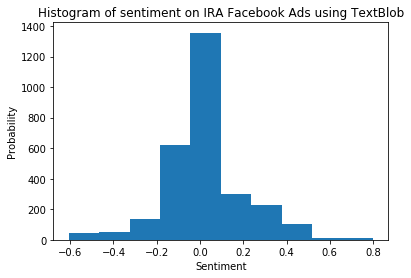

In [21]:
polarity=ira_data[ira_data['AD_TextBlob_SUBJECTIVITY'] < 0.8]
plt.hist(polarity['AD_TextBlob_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Histogram of sentiment on IRA Facebook Ads using TextBlob')

Text(0.5, 1.0, 'Histogram of subjectivity on IRA Facebook Ads')

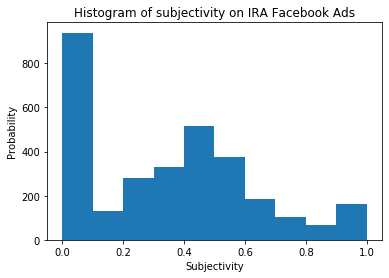

In [22]:
plt.hist(ira_data['AD_TextBlob_SUBJECTIVITY'])
plt.xlabel('Subjectivity')
plt.ylabel('Probability')
plt.title('Histogram of subjectivity on IRA Facebook Ads')

## Sentiment Analysis with VADER

In [23]:
analyzer = sid()
ira_data['AD_VADER_POLARITY']=ira_data['AD_TEXT'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
ira_data['AD_VADER_Sentiment'] = ira_data['AD_VADER_POLARITY'].apply(lambda x: 'positive' if x>=0.5 else ('negative' if x <= -0.5 else 'negative'))
ira_data['AD_VADER_Sentiment'].value_counts()

negative    2214
positive     877
Name: AD_VADER_Sentiment, dtype: int64

Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using VADER')

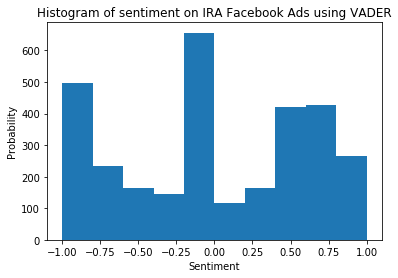

In [24]:
plt.hist(ira_data['AD_VADER_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Histogram of sentiment on IRA Facebook Ads using VADER')

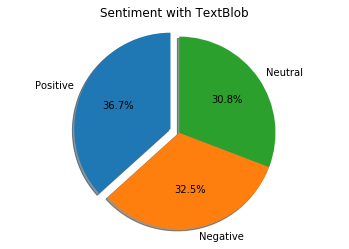

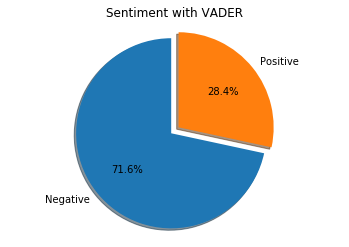

In [25]:
fig1, ax1 = plt.subplots()
explode = (0.1, 0, 0)
labels='Positive', 'Negative', 'Neutral'
ax1.pie(ira_data['AD_TextBlob_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Sentiment with TextBlob')

labels2 = 'Negative', 'Positive'
fig2, ax2 = plt.subplots()
ax2.pie(ira_data['AD_VADER_Sentiment'].value_counts(), explode=(0.1, 0), labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal') 
plt.title('Sentiment with VADER')

plt.show()

* * * * * * * * * *


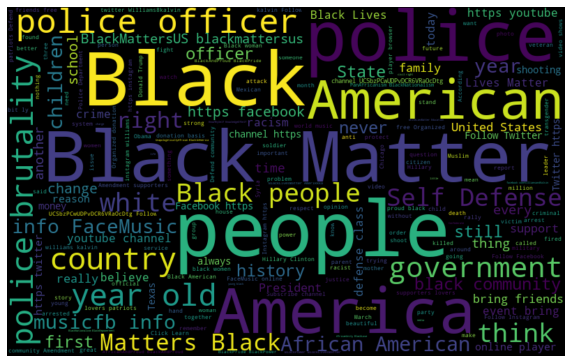

In [26]:
all_words = ' '.join([text for text in ira_data['AD_TEXT']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [27]:
ira_data = ira_data[ira_data['AD_TextBlob_Sentiment']==ira_data['AD_VADER_Sentiment']]

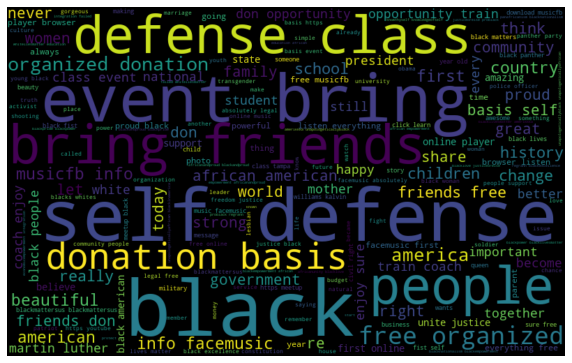

In [28]:
pos_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_TextBlob_POLARITY'] > 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

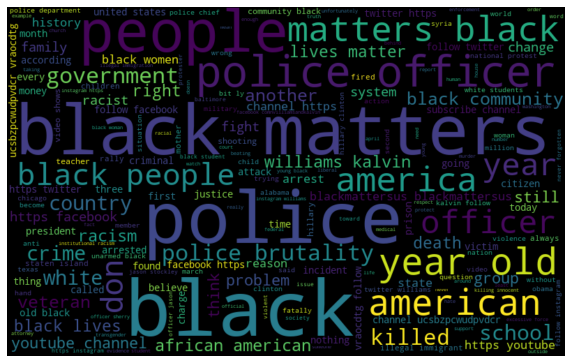

In [29]:
neg_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_TextBlob_POLARITY'] < 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [30]:
pd.set_option('display.max_colwidth', -1)
ira_data[ira_data['AD_VADER_Sentiment'] == "negative"][['AD_ORIGINAL_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_ORIGINAL_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
AD_ID,,,
2068,"Our deepest condolences to the victims and families in Manchester. We also wish people dedicate their sadness and thoughts to Syria, Flint, Bangkok or any other country which suffered from attacks and where the government cares only about money, not citizens.",-0.125000,-0.8074
3124,"Have seen good ones, but this is so far, in my opinion, the best #mannequinchallenge. Hands down!",-0.155556,0.0000
417,"There are people who generally believe racism is over, but minorities believe that there's a lot of racial discrimination in the United States of America. Thousands of African Americans experience discrimination due to inequality which results cultural failure and racial pathology. Do you realize that racism sits at the very core of American thinking?",-0.033333,-0.8658
2283,"25 years for rape, murder, and burglary for a man who didn't commit any of those crimes. Philadelphia is a place poisoned by police misconduct for so many years. That is the reason why they didn't immediately release an innocent man even after it wa Black Man Released After 25 Years Behind Bars For Nothing I Black Matters BM",-0.058333,-0.9485
1313,About $190 billion dollars are spent each year on illegal aliens for welfare & social services by the American taxpayers. Are leftists still sure that illegal immigration improves our economy?,-0.213333,-0.6597
2183,"Do you think that there is a place for racism in lawmaking? The answer seems to be obvious but white Alabama legislator, Lynn Greer, of Rogersville would disagree with you. Black lawmakers accuse their colleague of being racist and trying to minimize their influence. Black Lawmakers Enraged By Racist Email I BlackMattersUS.com blackmattersus.com",-0.083333,-0.9595
289,"The City of Somerville stands against all violence and all injustice, which is why a Black Lives Matter banner hangs at City Hall. Mayor Joseph Curtatone of Somerville, Massachusetts, boldly said he won't remove Black Lives Matter banner from the City Hall after the local police union asked Massachusetts Mayor Refuses To Remove BLM Banner From City Hall Black Matters Black Matters",-0.055556,-0.7096
1653,Attacker calls woman 'Muslim piece of trash' before pouring liquid on her in disturbing incident outside Starbucks in Washington 11111111,-0.250000,-0.7906
2401,"The video is circulating across the internet allegedly depicting a white NYPD officer raping a black 15-year-old girl in a jail cell. According to some sources, the incident took place in South Africa. However, there are some crucial points that are hidden from the society. A shocking video went viral of an on- duty white cop raping a young black teen in a jail, collecting numerous comments. Firstly, in the description box, it was w Major mismatches in the story of white cop raping 15 yo black girl I BM BM",-0.084635,-0.9590


In [31]:
ira_data[ira_data['AD_VADER_Sentiment'] == "positive"][['AD_ORIGINAL_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_ORIGINAL_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
AD_ID,,,
25,Homeland of brave. Support our veterans! Join us! Veterans USA GovSpending,0.800000,0.7500
65,"Two years have passed since August 11, 2014, the date. when 25-year-old Ezell Ford was mur Justice For Ezell Ford And Donnell Thompson",0.100000,0.5267
2385,We're proud to announce an initiative focused on providing free legal education to empower our people and strengthen our community. We believe that having these legal workshops on a monthly basis will prove to be beneficial in a tangible way for our community eet ou at Charlotte. NC Legal Night at= i,0.350000,0.9081
2018,"Mamoudou N'Diaye. a film maker; and a comedian made this amazing video to illustrate the various stereotypical roles given to people of colour in the movie industry over the past century. There are hundred's, maybe thousands, talented Black men in the film industry but we usually here only about Will Smith or Denzel Washington, here's why... How Black Men Are Stereotyped On Screen I BlackMattersUS.com blackmattersus.com",0.014583,0.8176
836,We're black and We're proud of it! Join to understand how beautiful we are!,0.494444,0.7906
3364,"Join the event, bring your friends, feel safe with us in It's free! Organized on a donation basis. https://www.meetup.com/Black-Fist- Self-Defense-Pro·ecU Free Self-Defense class in NY",0.116667,0.7712
2457,"Join us, if you proud to be who you are and believe that your roots give you the power!",0.800000,0.5255
2367,"We're proud to announce an initiative focused on providing free legal education to empower our people and strengthen our community. We urge our city to continue to support and defend our immigrant communities and their families. Immigrants and refugees are an integral part of our economy, our cultural and social life. and our future. Join the Legal Night meeting at on March 4. Legal Night at Free legal help for immigrants",0.216667,0.9136
3320,"Join the event, bring your friends, feel safe with us! Don't miss the opportunity to train outdoors! It's free! Organized on a donation basis. Free Self-defense class in Orlando, Fl",0.400000,0.6860
